## Actitracker dataset
Evaluation for capstone model-building.

#### load libraries

In [32]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

### Exploring the data

!cat WISDM_ar_v1.1_raw.txt | awk -F',' 'BEGIN { OFS=","; RS=";"; ORS=";"; } \
{ if (NF==6) { print $0,"" } else if (NF==7) { print $0 }}' > raw_data_fixed.txt

In [33]:
DATA_FOLDER = 'Data/WISDM_ar_v1.1/'
DATA_FILE = 'raw_data_fixed.txt'

In [34]:
actitracker = pd.read_csv(
    DATA_FOLDER+DATA_FILE ,
    sep=',' ,
    lineterminator=';' ,
    header=None ,
)

In [35]:
actitracker.columns = [
    'user' ,
    'activity' ,
    'timestamp' ,
    'x-accel' ,
    'y-accel' ,
    'z-accel' ,
    'NA' ,
]
del actitracker['NA']

In [36]:
actitracker[['x-accel','y-accel','z-accel']].describe()

,x-accel,y-accel,z-accel
count,1098208.000000,1098208.000000,1098208.000000
mean,0.662866,7.255626,0.411078
std,6.849046,6.746216,4.754120
min,-19.610000,-19.610000,-19.800000
25%,-2.870000,3.170000,-2.220000
50%,0.270000,7.930000,0.000000
75%,4.440000,11.560000,2.720000
max,19.950000,20.040000,19.610000


In [37]:
sample = np.random.choice(xrange(actitracker.shape[0]), 2000)

In [38]:
X, Y, Z = actitracker[['x-accel']].as_matrix()[sample].ravel() , \
actitracker[['y-accel']].as_matrix()[sample].ravel() , \
actitracker[['z-accel']].as_matrix()[sample].ravel()

[<matplotlib.text.Text at 0x11d92fa90>, <matplotlib.text.Text at 0x11d94ea10>]

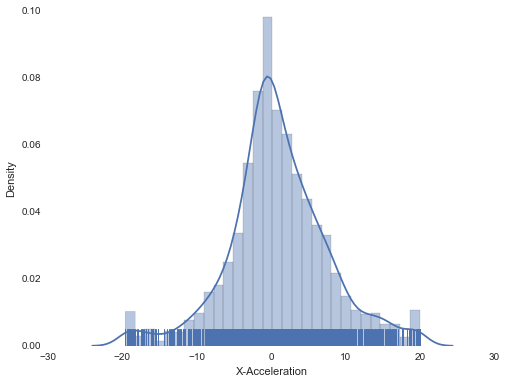

In [39]:
g = sns.distplot(X, bins=30, rug=True)
g.set(xlabel="X-Acceleration", ylabel='Density')

In [40]:
sp.stats.shapiro(X)

(0.975399374961853, 4.701606093425866e-18)

[<matplotlib.text.Text at 0x124406c10>, <matplotlib.text.Text at 0x124406a90>]

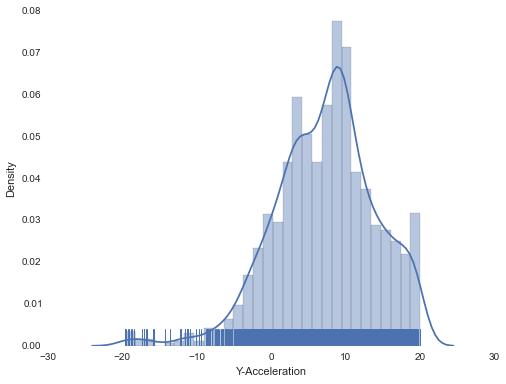

In [41]:
g = sns.distplot(Y, bins=30, rug=True)
g.set(xlabel='Y-Acceleration', ylabel='Density')

In [42]:
sp.stats.shapiro(Y)

(0.9767928719520569, 1.6890483823489765e-17)

[<matplotlib.text.Text at 0x12758f890>, <matplotlib.text.Text at 0x12758fcd0>]

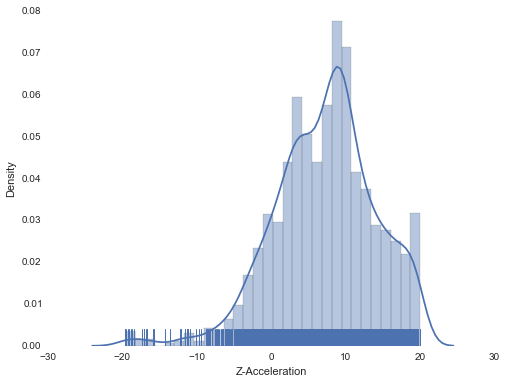

In [43]:
g = sns.distplot(Y, bins=30, rug=True)
g.set(xlabel='Z-Acceleration', ylabel='Density')

In [44]:
sp.stats.shapiro(Z)

(0.9806164503097534, 7.63597925548706e-16)

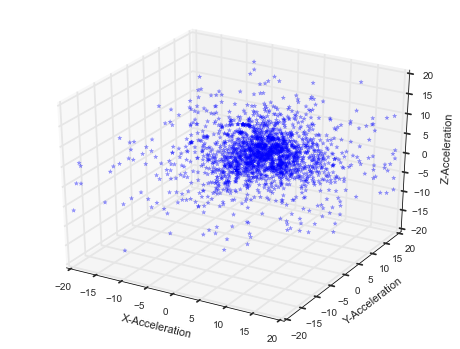

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lims = [-20,20]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_zlim(lims)
ax.set_xlabel('X-Acceleration')
ax.set_ylabel('Y-Acceleration')
ax.set_zlabel('Z-Acceleration')
plt.scatter(X, Y, zs=Z, axes=ax, marker='*', color='blue', alpha=0.4)

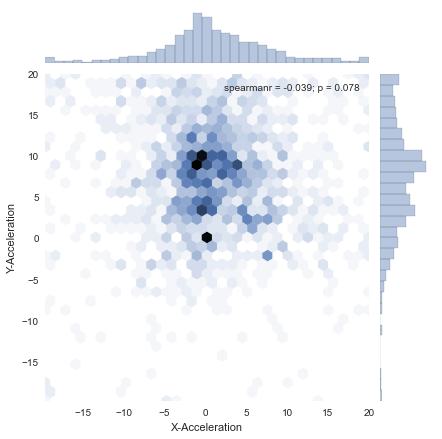

In [46]:
g = sns.jointplot(
    X ,
    Y ,
    stat_func=sp.stats.spearmanr,
    kind='hex',
)
g.set_axis_labels('X-Acceleration','Y-Acceleration')

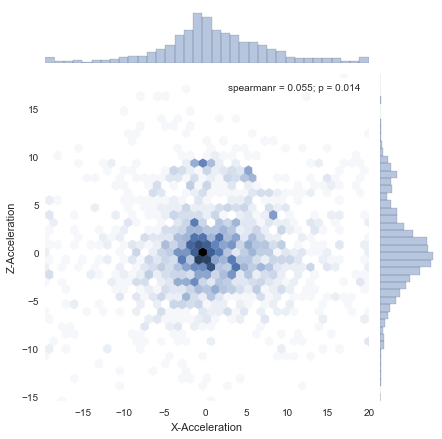

In [47]:
g = sns.jointplot(
    X ,
    Z ,
    stat_func=sp.stats.spearmanr,
    kind='hex',
)
g.set_axis_labels('X-Acceleration','Z-Acceleration')

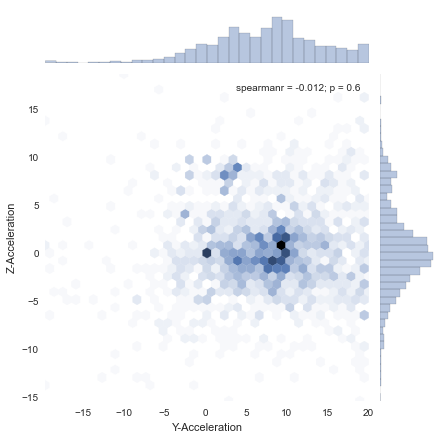

In [48]:
g = sns.jointplot(
    Y ,
    Z ,
    stat_func=sp.stats.spearmanr,
    kind='hex',
)
g.set_axis_labels('Y-Acceleration','Z-Acceleration')

In [49]:
D = actitracker.iloc[sample][['x-accel','y-accel','z-accel','activity']]

[<matplotlib.text.Text at 0x122c6a5d0>, <matplotlib.text.Text at 0x123007690>]

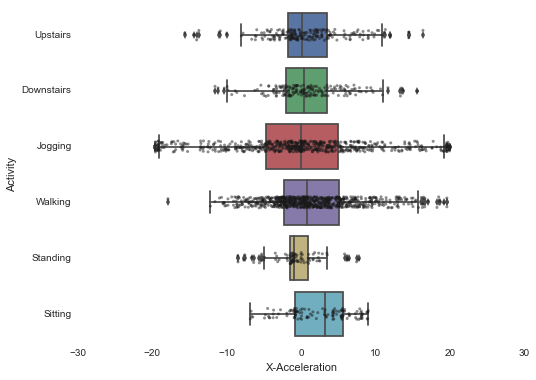

In [51]:
sns.boxplot(x='x-accel',y='activity',data=D)
g = sns.stripplot(x="x-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
g.set(xlabel='X-Acceleration',ylabel='Activity')

[<matplotlib.text.Text at 0x126b19050>, <matplotlib.text.Text at 0x126b19fd0>]

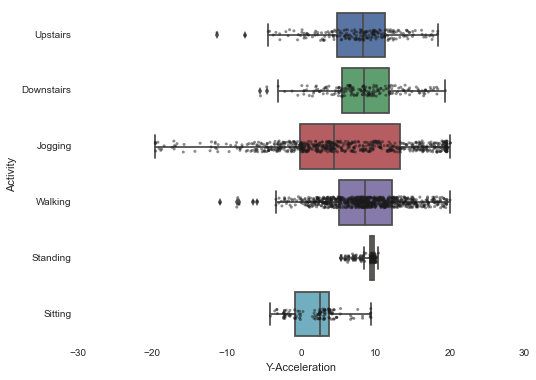

In [53]:
sns.boxplot(x='y-accel',y='activity',data=D)
g = sns.stripplot(x="y-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
g.set(xlabel='Y-Acceleration',ylabel='Activity')

[<matplotlib.text.Text at 0x1268a7e90>, <matplotlib.text.Text at 0x1268b8910>]

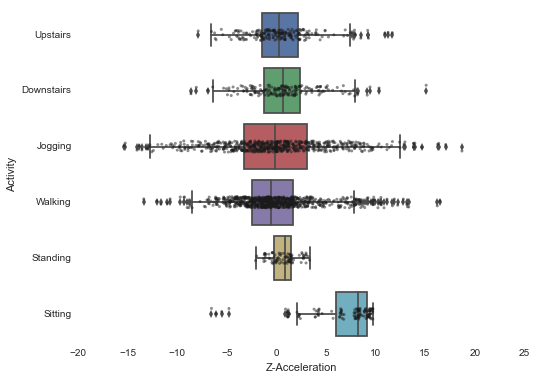

In [52]:
sns.boxplot(x='z-accel',y='activity',data=D)
g = sns.stripplot(x="z-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
g.set(xlabel='Z-Acceleration',ylabel='Activity')

### Evaluate time blocks

In [54]:
actitracker['time_seconds'] = actitracker['timestamp']*10e-9
actitracker = actitracker.sort_values(by=['user','time_seconds'])
actitracker.index = xrange(actitracker.shape[0])

In [55]:
offset_index = actitracker.iloc[1:].index
actitracker.loc[offset_index,'time_seconds_prev'] = actitracker.iloc[:-1]['time_seconds'].as_matrix()
actitracker.loc[offset_index,'prev_user'] = actitracker.iloc[:-1]['user'].as_matrix()

In [56]:
nonmatched_users = actitracker['user']!=actitracker['prev_user']
actitracker.loc[nonmatched_users,['time_seconds_prev','prev_user']] = np.nan

In [57]:
actitracker['time_diff'] = actitracker['time_seconds'] - actitracker['time_seconds_prev']

In [58]:
nan_filter = -np.isnan(actitracker['time_diff'])
actitracker['time_diff'].describe()

count    1098172.000000
mean           7.659919
std         2239.629216
min            0.000000
25%            0.495000
50%            0.499880
75%            0.500490
max      1296121.114820
Name: time_diff, dtype: float64

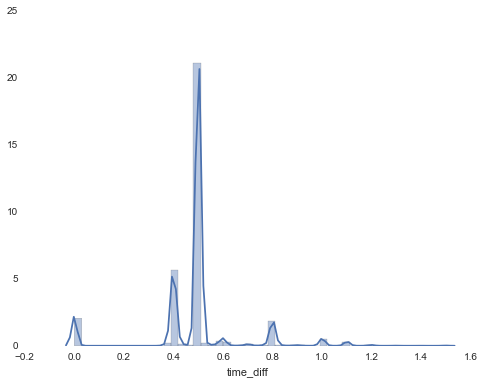

In [59]:
sns.distplot(actitracker.loc[actitracker['time_diff']<1.5,'time_diff'])

In [78]:
import matplotlib.cm as cm

In [70]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [92]:
p = PCA(2) 
p.fit(actitracker[['x-accel','y-accel','z-accel']])

PCA(copy=True, n_components=2, whiten=False)

In [93]:
np.cumsum(p.explained_variance_ratio_)

array([ 0.41657905,  0.80531244])

In [94]:
pca = p.transform(actitracker[['x-accel','y-accel','z-accel']])

In [96]:
k=10
km = KMeans(n_clusters=k)
km.fit(pca)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [98]:
clusters = km.predict(pca)

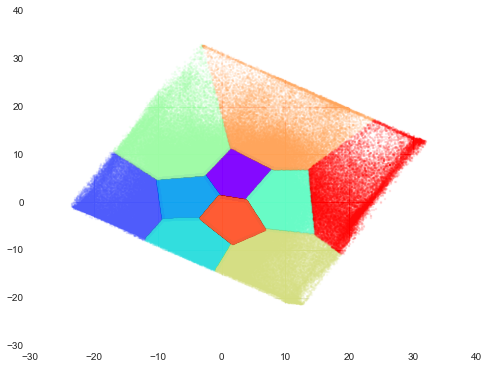

In [103]:
colors = cm.rainbow(np.linspace(0, 1, k))
for y, c in zip(xrange(k), colors):
    x = pca[clusters==y,:]
    plt.scatter(x[:,0], x[:,1], marker='.', alpha=0.1, color=c)

### UCI Dataset

In [60]:
DATA_FOLDER = 'Data/UCI HAR Dataset/'
DATA_FILE = 'train/X_train.txt'
COL_FILE = 'features.txt'

In [61]:
uci_dataset = pd.read_fwf(
    DATA_FOLDER+DATA_FILE ,
    sep='\s' ,
    header=None ,
)

In [62]:
colnames = pd.read_csv(
    DATA_FOLDER+COL_FILE,
    sep='\s',
    header=None,
).iloc[:,1].T

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


In [63]:
uci_dataset.columns = colnames

In [64]:
uci_dataset.head()

1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [65]:
X,Y,Z = uci_dataset.iloc[:,0],uci_dataset.iloc[:,1],uci_dataset.iloc[:,2]

[<matplotlib.text.Text at 0x13c84f850>, <matplotlib.text.Text at 0x13c85d410>]

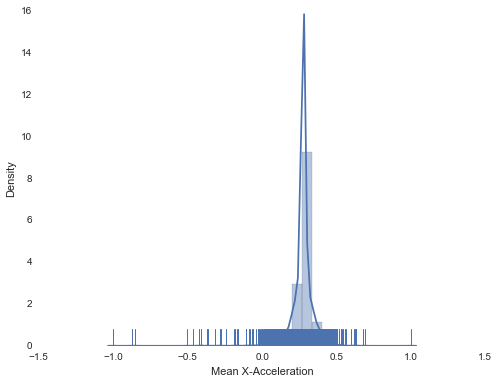

In [67]:
g= sns.distplot(X, bins=30, rug=True)
g.set(xlabel='Mean X-Acceleration',ylabel='Density')

[<matplotlib.text.Text at 0x13a23e710>, <matplotlib.text.Text at 0x13a24c950>]

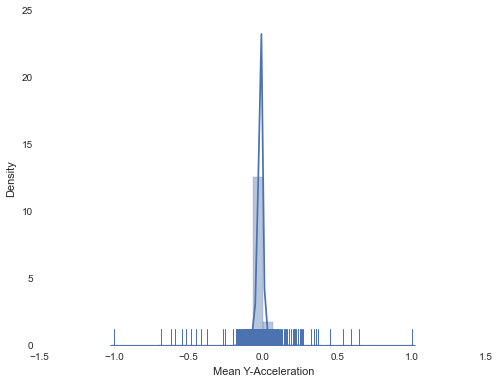

In [68]:
g = sns.distplot(Y, bins=30, rug=True)
g.set(xlabel='Mean Y-Acceleration',ylabel='Density')

[<matplotlib.text.Text at 0x147437310>, <matplotlib.text.Text at 0x1474466d0>]

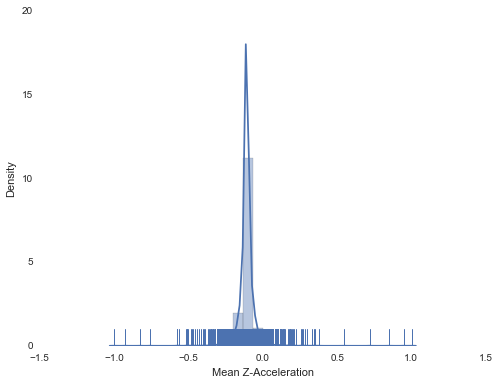

In [69]:
g = sns.distplot(Z, bins=30, rug=True)
g.set(xlabel='Mean Z-Acceleration',ylabel='Density')